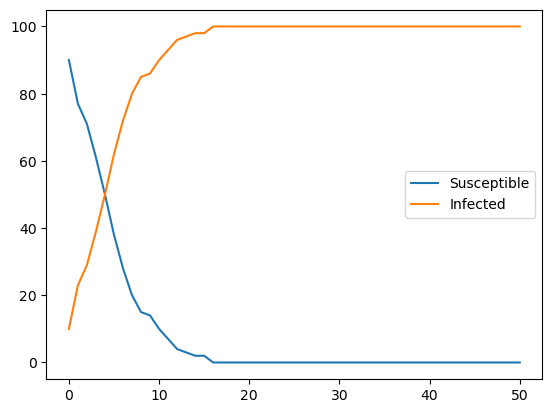

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def tau_leaping(S, c, X0, T, tau):
    """
    S: Stoichiometry matrix. Each row represents a reaction, and each column represents a species.
    c: Array of reaction rates.
    X0: Initial state.
    T: Total time.
    tau: Leap size.
    """
    t = 0.0
    X = []
    X.append(X0)
    i = 0

    for j in range(T):
        a = c*np.array([X[i][0]*X[i][1], X[i][0]])  # Propensity function
        K = np.random.poisson(a * tau)  # Number of reactions
        X_new = X[i] + np.dot(K, S)  # Update the state
        X.append(X_new)
        t += tau  # Update the time
        i = i+1

        # Check for negative populations
        if np.any(X[i] < 0):
            raise ValueError("Negative population")

    return X

# Example usage:
S = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([0.008, 0.1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 50  # Total time
tau = 0.3  # Leap size

X = tau_leaping(S, c, X0, T, tau)
plt.plot(range(len(X)), np.array(X)[:,0], label='Susceptible')
plt.plot(range(len(X)), np.array(X)[:,1], label='Infected')
plt.legend()

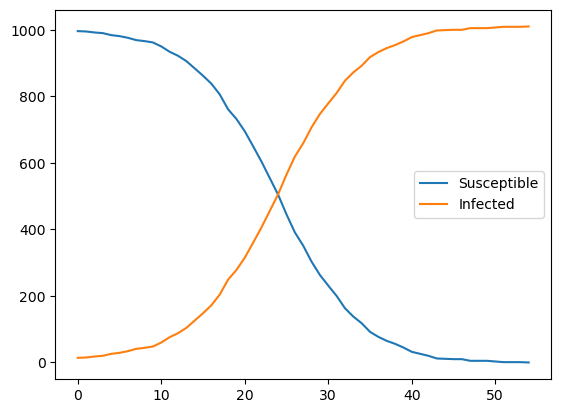

In [5]:
import pyro
import pyro.distributions as dist
import torch

# Initialize state variables
S = torch.tensor(1000.0)  # Number of susceptible individuals
I = torch.tensor(10.0)    # Number of infected individuals

# Initialize parameters
beta1 = 0.002  # Rate of S + I => 2I
beta2 = 0.001  # Rate of S => I
tau = 0.1      # Initial leap time
t = 0.0        # Start time
T_max = 100.0  # Maximum simulation time

s_hist = []
i_hist = []

# Define propensity function
def propensity(S, I, beta1, beta2):
    a1 = beta1 * S * I  # Propensity of S + I => 2I
    a2 = beta2 * S      # Propensity of S => I
    return torch.tensor([a1, a2])

# Define state update function
def update_state(S, I, reactions):
    S_new = S + reactions[0]
    I_new = I + reactions[1]
    return S_new, I_new

# Main \(\tau\)-leaping simulation loop
while t < T_max:
    # Calculate propensities
    propensities = propensity(S, I, beta1, beta2)
    a0 = propensities.sum()
    
    # Determine number of reaction events using Poisson distribution
    k1 = pyro.sample('k1', dist.Poisson(propensities[0] * tau))
    k2 = pyro.sample('k2', dist.Poisson(propensities[1] * tau))
    
    # Update state variables
    S, I = update_state(S, I, [-k1.item() - k2.item(), k1.item() + k2.item()])
    
    # Advance time
    t += tau

    # Output the state at this time point
    #print(f"Time: {t:.2f}, S: {S.item()}, I: {I.item()}")

    s_hist.append(S.item())
    i_hist.append(I.item())
    
    # Break if the system has no more susceptible individuals or if all are infected
    if S <= 0 or I <= 0:
        break

plt.plot(range(len(s_hist)), s_hist, label='Susceptible')
plt.plot(range(len(i_hist)), i_hist, label='Infected')
plt.legend()
plt.show()